In [67]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

### Read data

In [2]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")

In [ ]:
#resample to month ends
mhm_fluxes_mon= mhm_fluxes.resample(time='ME').mean()

In [ ]:
#select values for June
data=mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month==6)

#select a time series from a specific location
sample_ts = mhm_fluxes_mon['SM_Lall'].sel(lon=5.5, lat=51.5, method='nearest')
sample_ts1 = data['SWC_Lall'].sel(lon=slice(5.5,5.7), lat=slice(51.5,51.7)).mean(dim=['lat','lon'])

In [65]:
ts_df = sample_ts.to_dataframe().drop(columns=['lat', 'lon'])

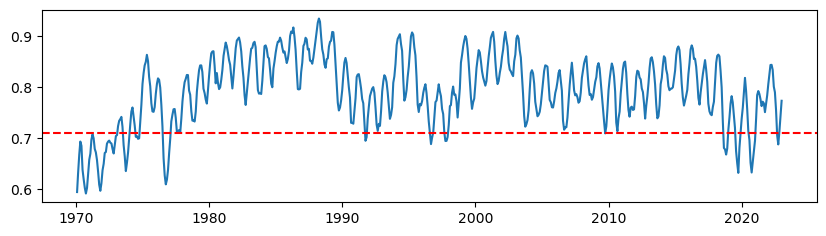

In [62]:
fig,ax=plt.subplots(figsize=(10,2.5))
plt.plot(ts_df.index, ts_df['SM_Lall'])
plt.axhline(y=0.71, color='r', linestyle='--')

In [7]:
#ts_df.to_numpy()
#extract values
soil_moisture = ts_df.values[:,0]

In [ ]:

# Define a range of bandwidths to test
bandwidths =np.linspace(0.001, 0.9, 500)

# Perform cross-validated grid search for bandwidth h
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(soil_moisture[:, None])

# Optimal bandwidth
optimal_h = grid.best_params_['bandwidth']
print(f"Optimal bandwidth: {optimal_h}")

Optimal bandwidth: 0.03883366733466934


Text(0.5, 0, 'sm')

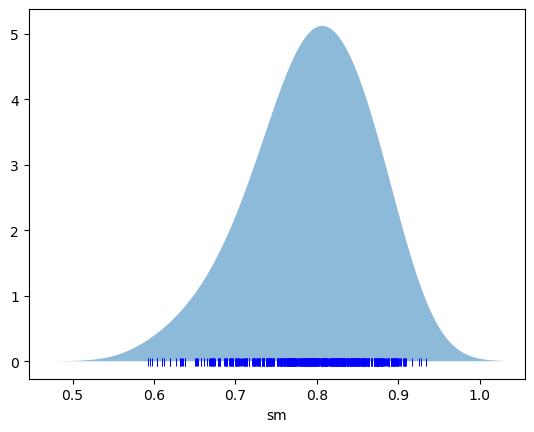

In [ ]:
# kernel density estimation
kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
kde.fit(soil_moisture[:, None]) #fit the KDE model to the data

#plot the kde
x = np.linspace(soil_moisture.min() * 0.8, soil_moisture.max() * 1.1, 1000) 
#x used for evaluating the kernel density estimation (KDE) does not have to be the same as the original data points.
#  Instead, x is typically chosen as a smooth, evenly spaced range of values that covers the domain of the data.
#  This ensures that the KDE curve is displayed smoothly over the range of interest.
# x is for the visualization of the KDE, not for determining the underlying probabilities of your data

#evaluate the KDE at the x values
#range of soil moisture values
logprob = kde.score_samples(x[:, None]) #log of the probability density function

#probability density function
prob_density = np.exp(logprob)

plt.fill_between(x, prob_density, alpha=0.5)

#plot vertical lines (|) representing the soil moisture values, with height equal to -0.01
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)
plt.xlabel('sm')

### cumulative distribution function

Text(0, 0.5, 'CDF')

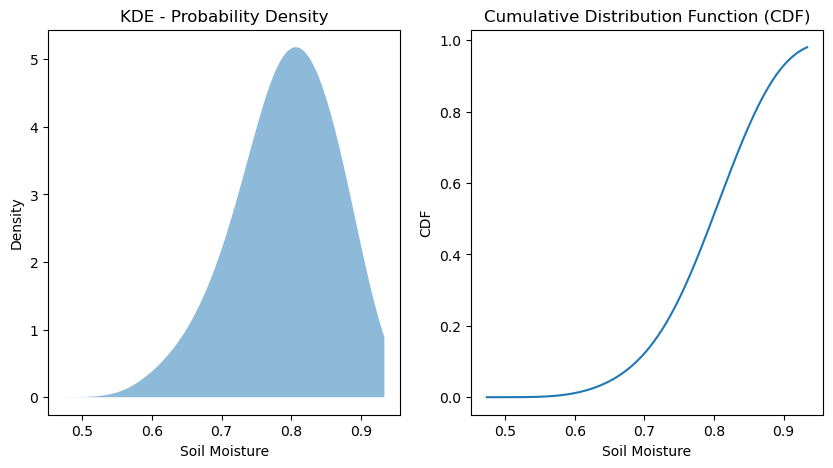

In [52]:
# Integrate the density to get the CDF
cdf = np.cumsum(prob_density) * (x[1] - x[0])  # numerical integration (trapezoidal rule)

# Plot the KDE and CDF for visualization
plt.figure(figsize=(10, 5))

# Plot KDE (probability density)
plt.subplot(1, 2, 1)
plt.fill_between(x, prob_density, alpha=0.5)
plt.title('KDE - Probability Density')
plt.xlabel('Soil Moisture')
plt.ylabel('Density')

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(x, cdf, label='CDF')
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Soil Moisture')
plt.ylabel('CDF')

In [59]:

# Calculate SMI for a specific observed soil moisture value (e.g., x_t = 0.75)
x_t = 0.72
smi = np.interp(x_t, x, cdf)  # Interpolate to find the CDF value at x_t

print(f"SMI for soil moisture {x_t}: {smi}")

SMI for soil moisture 0.72: 0.1732578897331958


In [50]:
from scipy.integrate import simpson

# Ensure you are passing the x and y values correctly
area_under_curve = simpson(np.exp(logprob), x=x)  # Explicitly specify the x argument
print(f"Area under the curve: {area_under_curve}")


Area under the curve: 0.9799846493210256


#### Bandwidth selection
https://towardsdatascience.com/bounded-kernel-density-estimation-2082dff3f47f

Silverman's rule of thumb, optimal when the underlying density being estimated is Gaussian

$h = \sigma * (\frac{4}{3n})^{-0.2}$

In [43]:
n=len(soil_moisture)
stdev = np.std(soil_moisture)

In [44]:
h = 1.0587*stdev*n**-0.2
h

0.01975391445034831